In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pfb
import conjugate_gradient as cg

In [2]:
# At 250 MSPS, one second of data is 250e6 samples
f"{1<<28:.2e} is about {(1<<28)/250e6:.2f} seconds of data"

'2.68e+08 is about 1.07 seconds of data'

In [3]:
# Consts
N = 1<<24 #size of all signals
DELTA = 0.353 # this is optimal and expressed in stdevs of each channel
NCHAN = 1025
NTAP = 4
NFRAME = NCHAN*2-2
print(f"N={N:.2e}, number of blocks is N/NFRAME={N//NFRAME} (2^{int(np.log2(N/NFRAME)+0.5)})")

N=1.68e+07, number of blocks is N/NFRAME=8192 (2^13)


In [4]:
def snr(signal, noise):
    assert signal.shape == noise.shape
    return 10 * np.log10(np.mean(abs(signal)**2)/np.mean(abs(noise)**2))

In [5]:
K=N>>int(np.log2(NCHAN) + 0.5 + 1)
print("K =", K)

K = 8192


In [6]:
ts = np.random.randn(N)
spec = pfb.forward_pfb(ts,nchan=NCHAN,ntap=NTAP)
stdre = np.std(np.real(spec)) # this could be more perfect, but it's practical
spec_quant = pfb.quantize_8_bit(spec, delta = stdre * DELTA)
print(f"Quantization SNR = {snr(spec, spec-spec_quant):.2f}")
# scale spec back 
# spec *= np.sqrt(NFRAME * NTAP) 
# spec_quant *= np.sqrt(NFRAME * NTAP)

Quantization SNR = 18.89


In [7]:
# Timestream reconstructed
ts_rec = pfb.inverse_pfb(spec, NCHAN, NTAP) # no wiener, fp precision
ts_rec_noisy = pfb.inverse_pfb(spec_quant, NCHAN, NTAP) # no wiener, quantized
ts_rec_wiener = pfb.inverse_pfb(spec_quant, NCHAN, NTAP, wiener_thresh=0.1)


# # Conjugate Gradient 5%, improvements
# _,saved_idxs_5 = cg.get_saved_idxs(n_per_save=10, prct=0.05, k=K, lblock=2048)
# N_inv = np.ones(len(ts)) * 6 / DELTA**2 # diagonal inverse noise matrix
# prior_5 = np.ones(len(ts)) # Noise matrix for prior
# prior_5[saved_idxs_5] = pfb.quantize_real(ts[saved_idxs_5].copy(), DELTA) # 8 bit quantized timestream
# Q_inv_5 = np.ones(len(ts)) # prior, change to zeros if you want zero for infinite uncertainty
# Q_inv_5[saved_idxs_5] = np.ones(len(saved_idxs_5)) * (12 / DELTA**2) # 8 bits per real number
# B_5 = lambda timestream: cg.AT(N_inv * cg.A(timestream)) + Q_inv_5 * timestream
# u_5 = cg.AT(N_inv * np.real(ts_rec_wiener)) + Q_inv_5 * prior_5

k = 8192


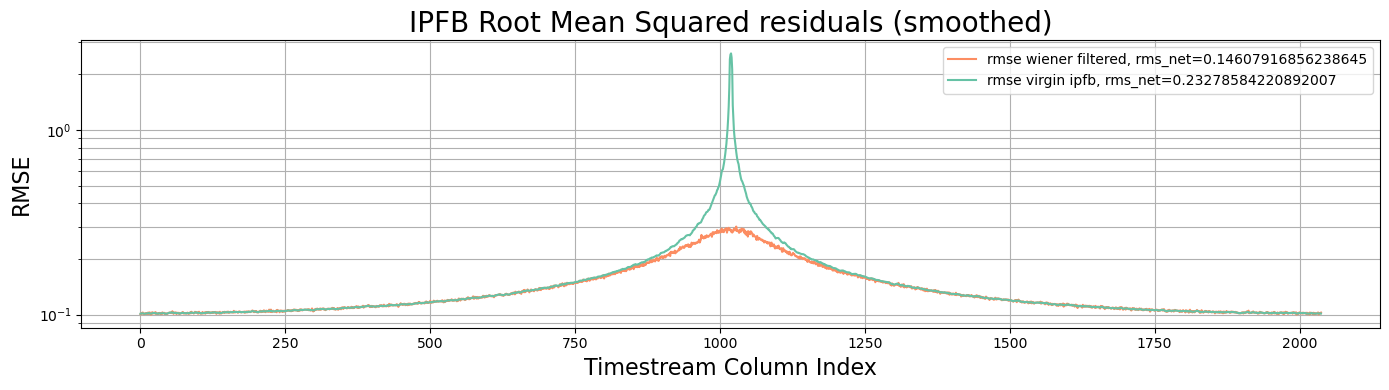

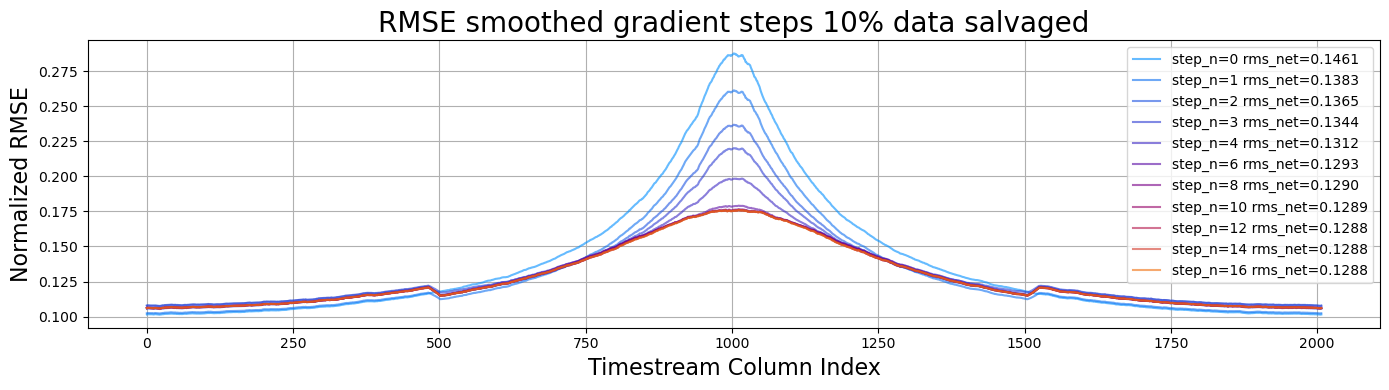

INFO: Conjugate Gradient descent completed.


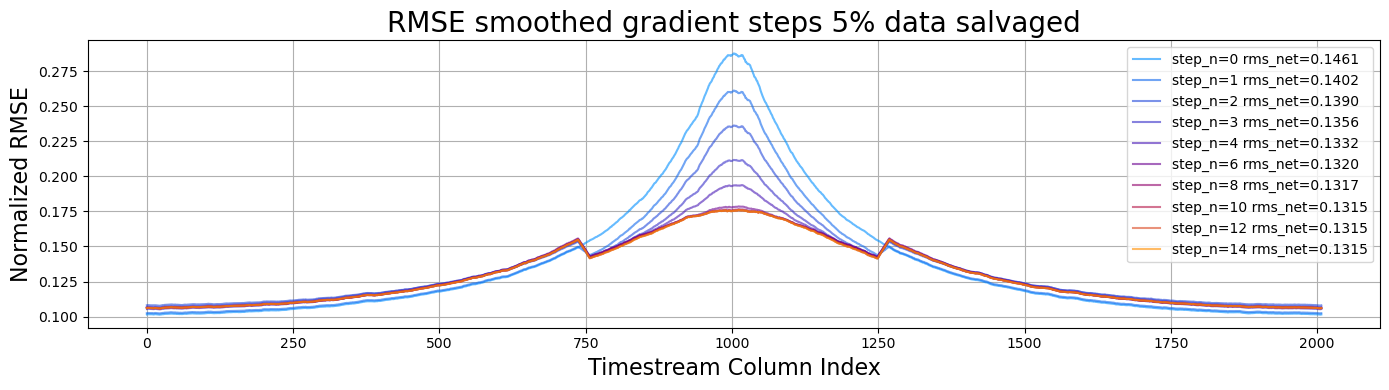

INFO: Conjugate Gradient descent completed.


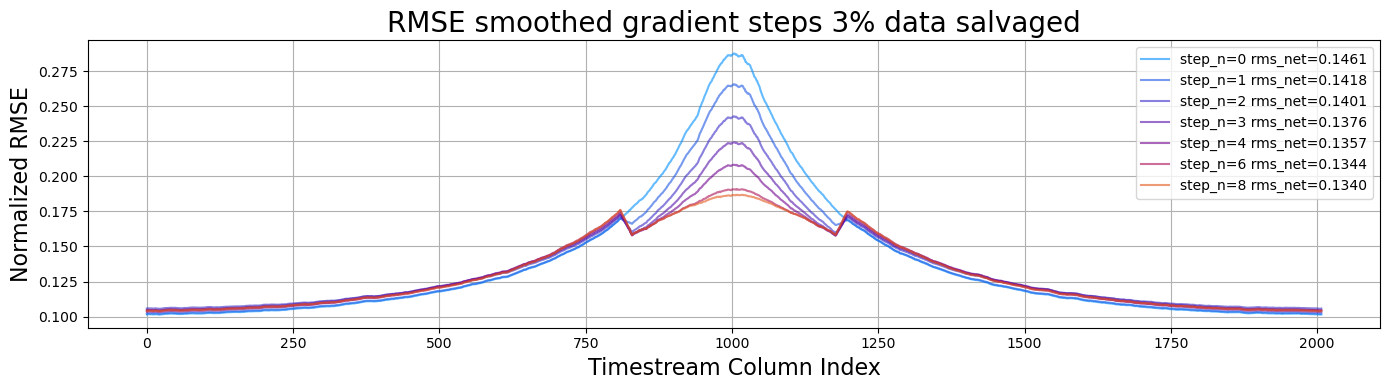

INFO: Conjugate Gradient descent completed.


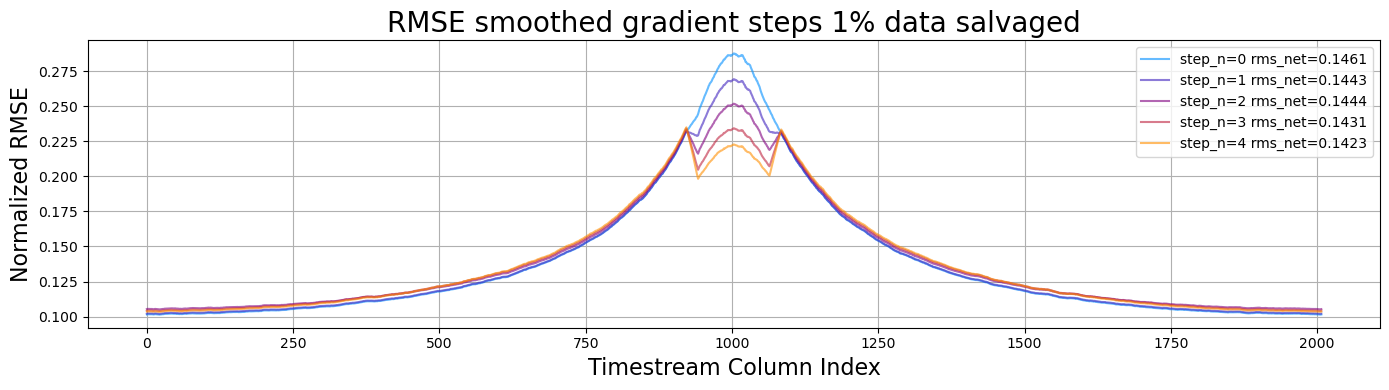

INFO: Conjugate Gradient descent completed.


In [8]:
# Conjugate Gradient 1,3,5,10 %
# k= 1<<13 
k = N//NFRAME
assert k == N//NFRAME # use full range of data for optimization
print("k =",k)
x0,x0wien,x10,x5,x3,x1 = cg.conj_grad_one_three_five_perc(
    x = ts[:NFRAME * k],
    delta = DELTA,
    k = k,
    lblock = NFRAME,
    verbose = True,
    wiener_thresh = 0.1
)

### Sanity check that x0 is equal to ts_rec_noisy 
They were implemented twice but should do same thing. 

In [9]:
print(x0)
print(np.real(ts_rec_noisy))
sanitydiff = x0-np.real(ts_rec_noisy)
print(f"std={np.std(sanitydiff):.1e}, max={np.max(sanitydiff):.1e}, min={np.min(sanitydiff):.1e} should be small number from roundoff error")

[ 1.25508935 -1.55255678 -0.04876299 ... -0.18741915 -0.5262553
 -0.65841923]
[ 1.26593423 -1.57763345 -0.03642606 ... -0.21387353 -0.51934053
 -0.65480162]
std=2.8e-02, max=1.0e+00, min=-1.0e+00 should be small number from roundoff error


### Look at what % gets clipped (for sanity)

In [10]:
ma,mi = np.max(np.real(spec_quant)),np.min(np.real(spec_quant))
pct = 100*len(np.where(np.real(spec).flatten() > ma)[0])*4 /len(spec.flatten())
# x4 because x2 for im+real, and x2 for min + max
#len(spec.flatten())
print(f"Percent clipped {pct:.7f}%")

Percent clipped 2.7039723%


### Plot quantized vs unquantized real part of the signal, for sanity

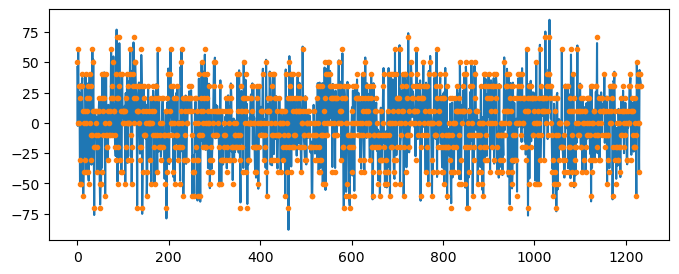

In [11]:
plt.figure(figsize=(8,3))
# idxs = np.arange(1234) + int(.75*1e7)
# idxs = np.arange(len(spec.flatten()))
idxs = np.arange(1234)
plt.plot(np.real(spec).flatten()[idxs])
plt.plot(np.real(spec_quant).flatten()[idxs],".")
plt.show()

### SNR of the quantized spec

In [12]:
spec_noise = spec - spec_quant
# print("mean of noise (shld be zero)",np.mean(spec_noise))
# print("std of spec noise",np.std(spec_noise))
# print("std of spec", np.std(spec))
print(f"SNR = {snr(signal=spec, noise=spec_noise):.1f} dB")

SNR = 18.9 dB


### SNR of the reconstructed timestream

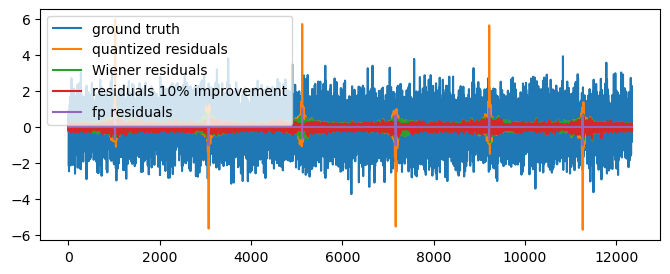

SNR of iPFB'd timestream after quantization 12.68 dB
SNR of iPFB'd timestream with Wiener filter 16.71 dB
SNR of iPFB'd timestream with 1% filter 16.98 dB
SNR of iPFB'd timestream with 3% filter 17.47 dB
SNR of iPFB'd timestream with 5% filter 17.62 dB
SNR of iPFB'd timestream with 10% filter 17.80 dB


In [13]:
res = ts - ts_rec
res_q = ts - ts_rec_noisy
res_wiener = ts - ts_rec_wiener
res_10 = ts - x10
#print(res)
idxs = np.arange(12345) + 32*5*NFRAME #+ int(.75*1e7)
#idxs = np.arange(len(ts))

plt.figure(figsize=(8,3))
plt.plot(ts[idxs],label="ground truth")
plt.plot(np.real(res_q[idxs]),label="quantized residuals")
plt.plot(np.real(res_wiener[idxs]),label="Wiener residuals")
plt.plot(np.real(res_10[idxs]),label="residuals 10% improvement")
plt.plot(np.real(res[idxs]),label="fp residuals")
#plt.plot(res[int(1e6):-int(1e6)])
plt.legend()
plt.show()

#idx_cliptrans = np.arange(int(1e7 * 0.2), int(1e7 * 1.5)) # just for rms stats, magic  numbers bad :'( 
idx_cliptrans = np.arange(32*5*NFRAME, len(ts) - 32*5*NFRAME)
#print(f"SNR of iPFB'd timestream with fp precision {snr(ts[idx_cliptrans],res[idx_cliptrans]):.2f} dB")
print(f"SNR of iPFB'd timestream after quantization {snr(ts[idx_cliptrans],res_q[idx_cliptrans]):.2f} dB")
print(f"SNR of iPFB'd timestream with Wiener filter {snr(ts[idx_cliptrans],res_wiener[idx_cliptrans]):.2f} dB")
for perc,x in ((1,x1),(3,x3),(5,x5),(10,x10)):
    print(f"SNR of iPFB'd timestream with {perc}% filter {snr(ts[idx_cliptrans],(ts-x)[idx_cliptrans]):.2f} dB")

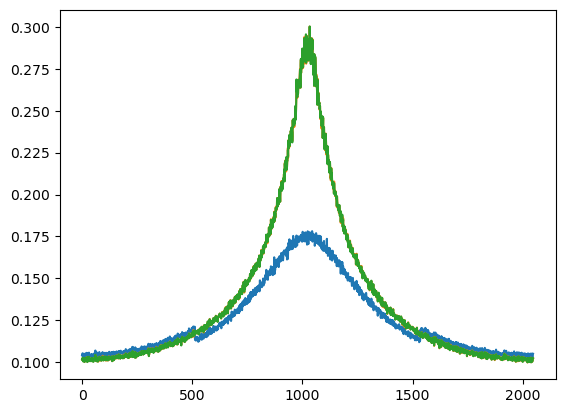

In [14]:
plt.plot(np.std(np.reshape(res_10[idx_cliptrans],(len(idx_cliptrans)//2048,2048)), axis=0))
plt.plot(np.std(np.reshape(res_wiener[idx_cliptrans],(len(idx_cliptrans)//2048,2048)), axis=0))
plt.plot(np.std(np.reshape((ts - x0wien)[idx_cliptrans],(len(idx_cliptrans)//2048,2048)), axis=0))

# Re channelize
### And compare SNR of Wiener vs no-Wiener re-channelizations

In [16]:
c = np.log2(10)/20 # constant to go from SNR to ENOB

In [17]:
# The number following spec is the number of channels (minus 1 for DC)
nchan=1024 * (1<<5) + 1
nframe=2*nchan-2

po2 = (len(idx_cliptrans)>>18)<<18 # make sure it's a power of 2, this is some poorly coded ad-hock bs
ts_clipped = ts[idx_cliptrans][:po2]
ts_quant_clipped = ts_rec_noisy[idx_cliptrans][:po2]
ts_wiener_clipped = ts_rec_wiener[idx_cliptrans][:po2]

spec_true = pfb.forward_pfb(ts_clipped, nchan=nchan, ntap=NTAP) # same spec
spec_quan = pfb.forward_pfb(np.real(ts_quant_clipped), nchan=nchan, ntap=NTAP)
spec_wien = pfb.forward_pfb(np.real(ts_wiener_clipped), nchan=nchan, ntap=NTAP) 

print(f"Rechannelized from {NCHAN} (2^{int(np.log2(NCHAN)+0.5)}) \
channels to {nchan} (2^{int(np.log2(nchan)+.5)}) channels\n")

print(f"No Wiener\tSNR = {snr(spec_true, spec_true - spec_quan):.2f} dB\tENOB = {snr(spec_true, spec_true - spec_quan)*c:.2f}")
print(f"With Wiener\tSNR = {snr(spec_true, spec_true - spec_wien):.2f} dB\tENOB = {snr(spec_true, spec_true - spec_wien)*c:.2f}")
for perc,x in ((1,x1),(3,x3),(5,x5),(10,x10)):
    spec_with_prior = pfb.forward_pfb(x[idx_cliptrans][:po2], nchan=nchan, ntap=NTAP)
    print(f"{perc}% prior\tSNR = {snr(spec_true, spec_true - spec_with_prior):.2f} dB\tENOB = {snr(spec_true, spec_true - spec_with_prior)*c:.2f}")

print(f"Rem, base\tSNR = {snr(spec, spec - spec_quant):.2f} dB\tENOB = {snr(spec, spec - spec_quant)*c:.2f}")

Rechannelized from 1025 (2^10) channels to 32769 (2^15) channels

No Wiener	SNR = 12.13 dB	ENOB = 2.01
With Wiener	SNR = 16.70 dB	ENOB = 2.77
1% prior	SNR = 16.98 dB	ENOB = 2.82
3% prior	SNR = 17.47 dB	ENOB = 2.90
5% prior	SNR = 17.47 dB	ENOB = 2.90
10% prior	SNR = 17.65 dB	ENOB = 2.93
Rem, base	SNR = 18.89 dB	ENOB = 3.14


### Information Analysis of Mat Eig

In [37]:
0.8715 * 18.9, 0.8715 * 3.14

(16.47135, 2.7365100000000004)